# 10章 : 拡散モデルの応用

## 条件付け拡散モデル
拡散モデルは以下
$$
\begin{align}
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right) &= \mathcal{N}\left(\boldsymbol{x}_{t-1}; \boldsymbol{\mu}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right), \sigma_q^2\left(t\right)\boldsymbol{I}\right)\\
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0\right) &= \int p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots, \boldsymbol{x}_T\right)d\boldsymbol{x}_1 d\boldsymbol{x}_2\cdots d \boldsymbol{x}_T \quad \left(\text{確率の周辺化}\right)\\
&= \int p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)\cdots p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{T-1} \mid \boldsymbol{x}_T\right) p \left(\boldsymbol{x}_T\right)d\boldsymbol{x}_1 d\boldsymbol{x}_2\cdots d \boldsymbol{x}_T \quad \left(\text{マルコフ性}\right)
\end{align}
$$

条件$y$を加えた条件付き拡散モデルは以下
$$
\begin{align}
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid y\right)
&= \int p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1, y\right)\cdots p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{T-1} \mid \boldsymbol{x}_T, y\right) p \left(\boldsymbol{x}_T\right)d\boldsymbol{x}_1 d\boldsymbol{x}_2\cdots d \boldsymbol{x}_T\\
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, y\right) &= \mathcal{N}\left(\boldsymbol{x}_{t-1}; \boldsymbol{\mu}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, y\right), \sigma_q^2\left(t\right)\boldsymbol{I}\right)
\end{align}
$$

## 条件付け拡散モデルの実装

In [1]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )
    
    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v) # ブロードキャスト
        return y

In [2]:
def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device) # [0, 1, ... , D-1]
    div_term = 10000 ** (i / D)

    v[0::2] = torch.sin(t / div_term[0::2]) # 偶数index
    v[1::2] = torch.cos(t / div_term[1::2]) # 奇数index
    
    return v

def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

条件$y$をEmbeddingでベクトル化して時刻$t$を位置エンコーディンしたものと足し合わせる
`nn.Linear()`と`nn.Embedding()`の違いは以下参照
- https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
- linearはただの線形変換で行列$A$とバイアス$b$を学習
- Embeddingはテンソルの階数が1個増える

In [4]:
# 条件付けUNetの実装(入力:x, t, yにも対応できるように拡張)
class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)
    
    def forward(self, x, timesteps, labels=None):
        # 正弦波位置エンコーディング
        t = pos_encoding(timesteps, self.time_embed_dim, x.device)

        # ラベルの処理(条件付け)
        if labels is not None:
            t += self.label_emb(labels)
        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)
        
        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x

データ生成実装

In [10]:
from tqdm import tqdm # プログレスバーを表示するため
import torchvision.transforms as transforms

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise
    
    # デノイズ処理
    def denoise(self, model, x, t, labels): # labels追加
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストのため
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0 # t=1のノイズは0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) /(1 - alpha_bar))
        return mu + noise * std
    
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        # labelランダムに生成
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)
        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)
        
        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

学習コード実装

100%|██████████| 1000/1000 [01:29<00:00, 11.13it/s]


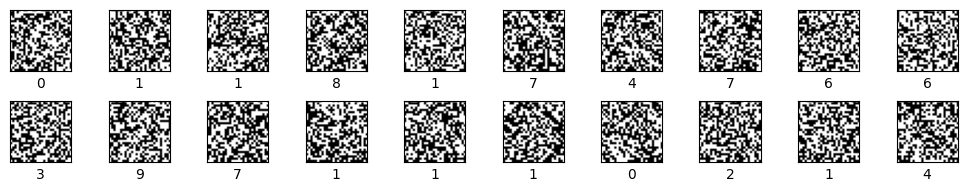

  3%|▎         | 12/469 [00:20<12:46,  1.68s/it]


KeyboardInterrupt: 

In [11]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

num_timesteps = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
epochs = 10
batch_size = 128

preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    images, labels = diffuser.sample(model)
    show_images(images, labels)
    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)